In [118]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import time

from copy import deepcopy
from math import ceil
import scipy
from scipy.io.wavfile import write

In [119]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [120]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

In [121]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [122]:
play = False
if play :
    play_sound(sound) 

In [123]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [124]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

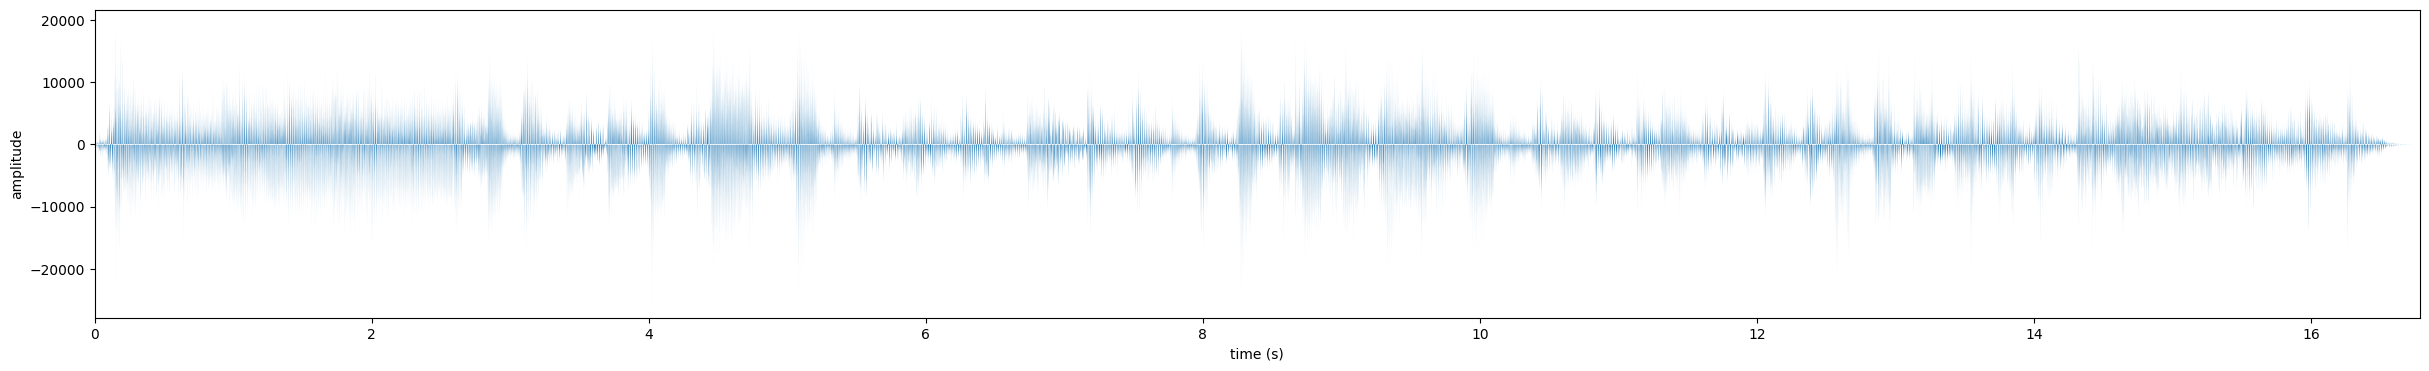

In [125]:
plot_sound(x, times)

In [126]:
def oversample(X,step):
    oversampled = np.zeros(len(X) * step)
    oversampled[::step] = X  # Place elements of X at every other position
    return oversampled


def downsampling(X,step):
    return X[::step]

In [127]:
def filter(data):
    X_over = oversample(data,2)
    ranges = np.arange(len(data))
    sinc_filter = (2/6)*np.sinc(2*np.pi*1/6*ranges)
    X_conv = scipy.signal.fftconvolve(X_over,sinc_filter,mode='same')
    print("finished")
    X_down = downsampling(X_conv,3)
    return X_down

In [128]:
X = filter(data)
write('new_caravan.wav', Fs, np.array(X, dtype=np.int16)) # to write a new wave file
print("finished uploading music")
timestep = 1/float(Fs*2//3)
times = np.arange(len(X))*timestep

finished
finished uploading music


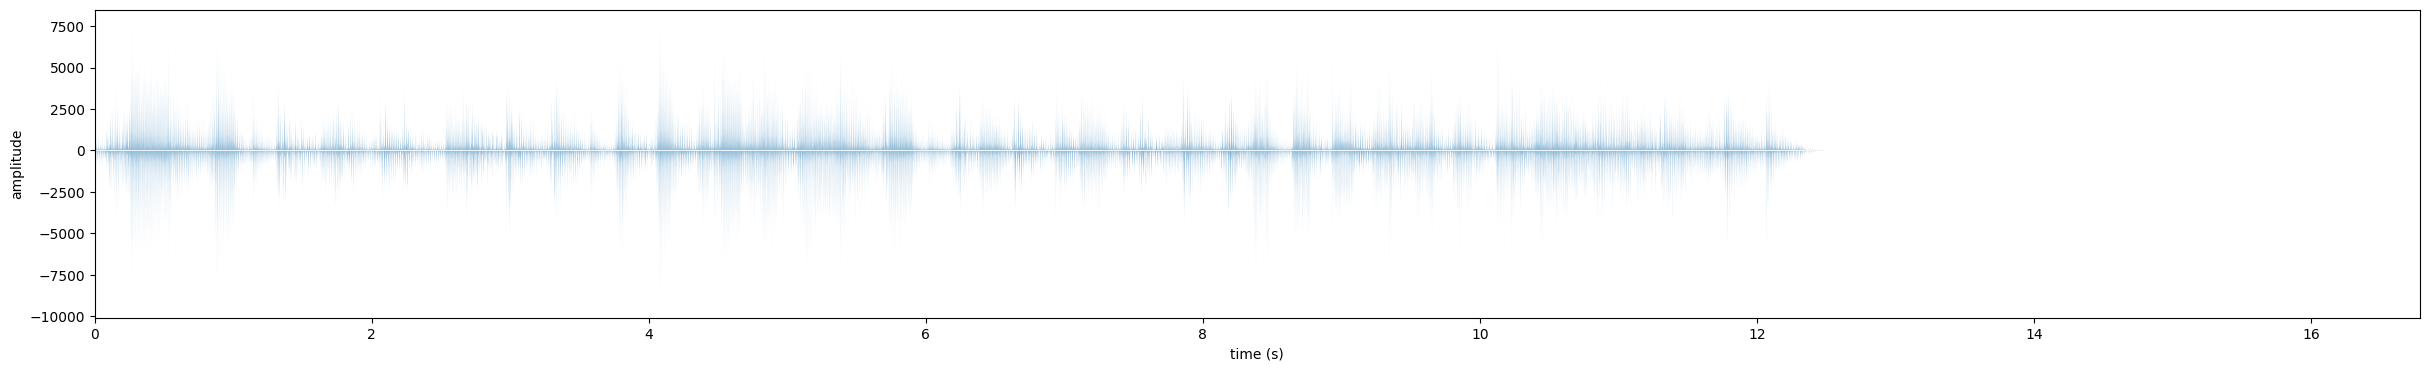

In [129]:
plot_sound(X,times)

In [130]:
def unoptimized_shift(X,step1,step2):

    start = time.time()
    h = scipy.signal.remez(400,[0,0.14,0.16,0.5],[2 ,0])
    E_0 = h[::2]
    E_1 = h[1::2]
    E_1 = np.roll(E_1,1)
    X_over = oversample(X, step1)
    X_result = scipy.signal.lfilter(E_0,[1],X_over) + scipy.signal.lfilter(E_1,[1],X_over)
    X_result = downsampling(X_result,step2)
    end = time.time()
    print(f"Execution time : {end-start}")
    return X_result

In [131]:
def optimized_shift(X,step1, step2):

    start = time.time()
    h = scipy.signal.remez(400,[0,0.14,0.16,0.5],[2 ,0])
    E_0 = h[::2]
    E_1 = h[1::2]
    X = X.astype(float)
    X_1 = scipy.signal.lfilter(E_0,[1],X)
    X_2 = scipy.signal.lfilter(E_1,[1],X)
    X_1 = oversample(X_1, step=step1)
    X_2 = oversample(X_2, step=step1)
    X_2 = np.roll(X_2, 1)
    X_out = X_1 + X_2
    X_out = downsampling(X_out, step=step2)
    end = time.time()
    print(f"Exectuion time: {end-start}")
    return X_out

In [132]:
#compute the outputs and compare the execution time, may take up to 20 seconds !
X = unoptimized_shift(X=x,step1= 2,step2 = 3)
X_out = optimized_shift(X=x,step1=2, step2 = 3)

Execution time : 0.10631775856018066
Exectuion time: 0.06117677688598633


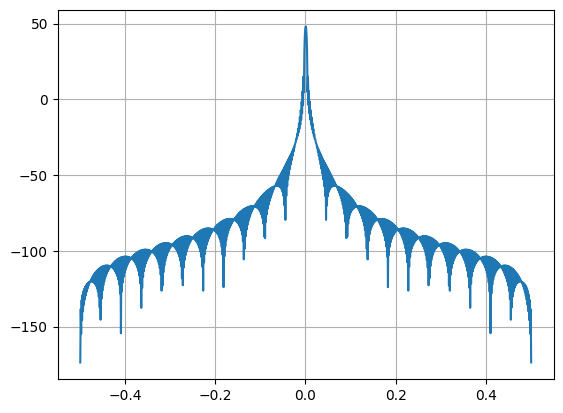

In [133]:
Nw = 512
M = 1000 # ordre de la tfd
w = np.hanning(Nw)
TFW = np.fft.fft(w,M)
TFW = np.abs(np.fft.fftshift(TFW))
mu = np.linspace(-0.5,0.5, M)

with np.errstate(divide='ignore', invalid='ignore'):
    TFW = 20 * np.log10(TFW)

indexes = np.arange(len(TFW))

plt.grid()
plt.plot(mu[1:],TFW[1:])
plt.show()

In [134]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = int((M/2) + 1)
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((L,Nt),dtype=complex)

##############################################################################################

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,L) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    
    h = [M, [0, -1/6, 1/6, 0.5] , ]

    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]


In [135]:
#Plating real part of the music

music = True

if music: 
    print("Writing music on file")
    write('STFT_noise.wav', Fs, np.array(np.real(Xtilde[3, :]), dtype=np.int16)) # to write a new wave file
    file_path = 'STFT_noise.wav'

Writing music on file


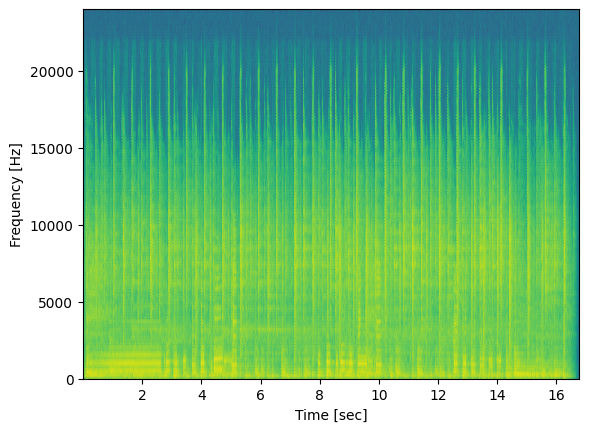

In [136]:
import scipy.signal


f, t , Sxx = scipy.signal.spectrogram(np.real(Xtilde[3 , : ]),Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()



Code Ola

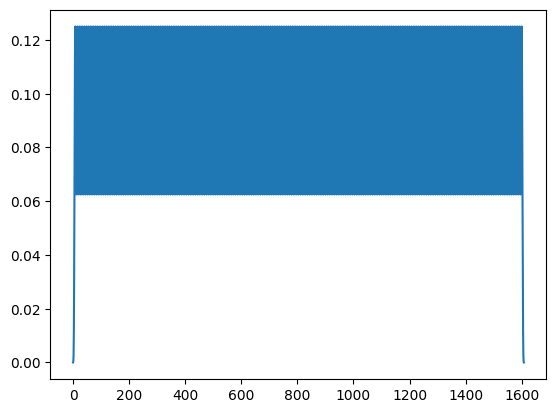

In [141]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

#############################################################################

M = 32
w = np.hanning(L)
H = np.sum(w)

h = w/np.sqrt(H)
Hanning = ola(h**2, int(0.25*M),200)
plt.plot(Hanning)
plt.show()


/tmp/ipykernel_114572/1665022471.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_s[:, u] = np.fft.ifft((Xtilde[:, u]),L) * h


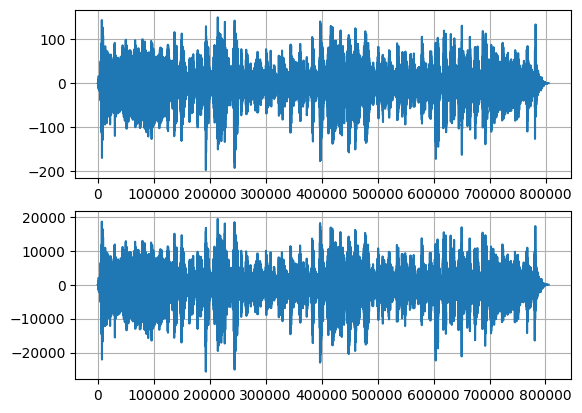

In [142]:
N = x.shape[0] # % longueur du signal
Nw = 16
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R =1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = int(M/2 + 1) #Channels
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)


#signal reconstruction
y_s = np.zeros(Xtilde.shape)

for u in range(Xtilde.shape[1]) :
    y_s[:, u] = np.fft.ifft((Xtilde[:, u]),L) * h

reconstruction = np.zeros(Nw + y_s.shape[1])

for k in np.arange(0, y_s.shape[1]).reshape(-1) :
    deb = k*R
    fin = deb + Nw
    reconstruction[np.arange(deb, fin)] = reconstruction[np.arange(deb, fin)] + y_s[:Nw, k]

fig , ax = plt.subplots(2)
ax[0].grid()
ax[1].grid()
ax[0].plot(reconstruction, label="reconstructed sinal")
ax[1].plot(x, label='real signal')
plt.show()

In [143]:
write('reconstructed_noise.wav', Fs, np.array(np.real(reconstruction), dtype=np.int16)) # to write a new wave file